<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/Census_Income.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! nvidia-smi

Sun Aug  2 16:22:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q torch_optimizer
import torch_optimizer as optim

In [ ]:
# Basics
import os
import math
import copy
import pandas as pd
import numpy as np

# PyTorch
import torch 
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader

# Sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import quantile_transform
from sklearn.preprocessing import power_transform, PowerTransformer
from sklearn.metrics import roc_auc_score

# Plots
from matplotlib import pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

manual_seed = 0
def deterministic(rep=True):
    if rep:
        np.random.seed(manual_seed)
        torch.manual_seed(manual_seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(manual_seed)
            torch.cuda.manual_seed_all(manual_seed)
        torch.backends.cudnn.enabled = False 
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        print(f'Deterministic experiment, seed: {manual_seed}')
    else:
        print('Random experiment')

deterministic()

Deterministic experiment, seed: 0


# Dataset - Cencus Income

In [ ]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num','marital-status', 'occupation', 'relationship', 'race', 'gender','capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']

train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tabular/adult_data.txt', sep=",\s", header=None, names = column_names, engine = 'python')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tabular/adult_test.txt', sep=",\s", header=None, names = column_names, engine = 'python')
test['income'].replace(regex=True,inplace=True,to_replace=r'\.',value=r'')

print(f'train shape {train.shape}')
print(f'test shape {test.shape}')

adult = pd.concat([test,train])
adult.reset_index(inplace = True, drop = True)
print(f'dataset shape {adult.shape}')
adult.head()

train shape (32561, 15)
test shape (16281, 15)
dataset shape (48842, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


### Dtypes

In [ ]:
for col in set(adult.columns) - set(adult.describe().columns):
    adult[col] = adult[col].astype('category')
    
print('## 1.1. Columns and their types')
print(adult.info())

## 1.1. Columns and their types
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              48842 non-null  int64   
 1   workclass        48842 non-null  category
 2   fnlwgt           48842 non-null  int64   
 3   education        48842 non-null  category
 4   educational-num  48842 non-null  int64   
 5   marital-status   48842 non-null  category
 6   occupation       48842 non-null  category
 7   relationship     48842 non-null  category
 8   race             48842 non-null  category
 9   gender           48842 non-null  category
 10  capital-gain     48842 non-null  int64   
 11  capital-loss     48842 non-null  int64   
 12  hours-per-week   48842 non-null  int64   
 13  native-country   48842 non-null  category
 14  income           48842 non-null  category
dtypes: category(9), int64(6)
memory usage: 2.7 MB
None


### NaNs?

In [ ]:
# NaN == 
def check_nan(df):
    for i, j in zip(df.columns,(df.values.astype(str) == '?').sum(axis = 0)):
        if j > 0:
            print(str(i) + ': ' + str(j))

In [ ]:
# train
check_nan(train)

workclass: 1836
occupation: 1843
native-country: 583


In [ ]:
# test
check_nan(test)

workclass: 963
occupation: 966
native-country: 274


### Trocar o ? por NaN

In [ ]:
train_nan = np.where(train.values == '?', np.nan, train.values)
train_nan = pd.DataFrame(train_nan, columns=train.columns)

test_nan = np.where(test.values == '?', np.nan, test.values)
test_nan  = pd.DataFrame(test_nan, columns=train.columns)

In [ ]:
train_nan['workclass'].nunique(), train_nan['occupation'].nunique(), train_nan['native-country'].nunique() 

(8, 14, 41)

In [ ]:
train_nan.isnull().sum()

age                   0
workclass          1836
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         1843
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      583
income                0
dtype: int64

In [ ]:
test_nan['workclass'].nunique(), test_nan['occupation'].nunique(), test_nan['native-country'].nunique() 

(8, 14, 40)

In [ ]:
test_nan.isnull().sum()

age                  0
workclass          963
fnlwgt               0
education            0
educational-num      0
marital-status       0
occupation         966
relationship         0
race                 0
gender               0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     274
income               0
dtype: int64

In [ ]:
train_mask = train_nan.copy()
train_mask = np.where(train_mask.isnull() == True, np.nan, 0)

test_mask = test_nan.copy()
test_mask  = np.where(test_mask.isnull() == True, np.nan, 0)

train_mask.shape, np.isnan(train_mask).sum(), test_mask.shape, np.isnan(test_mask).sum()

((32561, 15), 4262, (16281, 15), 2203)

### Trocar o np.nan por string NAN para o LabelEncoder() não quebrar, depois volta os np.nan com as Masks criadas


In [ ]:
train_nan.fillna('NAN', inplace=True)
test_nan.fillna('NAN', inplace=True)
train_nan.isnull().sum().sum(), test_nan.isnull().sum().sum()

(0, 0)

In [ ]:
print(train_nan['workclass'].nunique(), train_nan['occupation'].nunique(), train_nan['native-country'].nunique())
print(test_nan['workclass'].nunique(), test_nan['occupation'].nunique(), test_nan['native-country'].nunique())

9 15 42
9 15 41


### Conferindo os tipos das col (identificar cols. categóricas)

In [ ]:
train_nan.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object

### Separando o dataset em Cols Cat e Cols cont.
- Todas as cols object type


In [ ]:
cat_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
             'race'     , 'gender'   , 'native-country', 'income']

cont_cols = ['age'         , 'fnlwgt'      , 'educational-num', 
             'capital-gain', 'capital-loss', 'hours-per-week' ]

print(len(cat_cols) + len(cont_cols))

15


In [ ]:
df_cat_train  = train_nan[cat_cols].copy()
df_cont_train = train_nan[cont_cols].copy()

df_cat_test  = test_nan[cat_cols].copy()
df_cont_test = test_nan[cont_cols].copy()

In [ ]:
def transform_cat_label(df):
    categorical_dims = {}
    
    for col in df.columns:
        print(col, df[col].nunique())
        l_enc = LabelEncoder()
        df[col] = l_enc.fit_transform(df[col].values)
        categorical_dims[col] = len(l_enc.classes_)

    categorical_dims.pop('income')     # target
    return list(categorical_dims.values())

In [ ]:
cat_train = transform_cat_label(df_cat_train)
cat_test = transform_cat_label(df_cat_test)
print(cat_train, '\n',cat_test)

workclass 9
education 16
marital-status 7
occupation 15
relationship 6
race 5
gender 2
native-country 42
income 2
workclass 9
education 16
marital-status 7
occupation 15
relationship 6
race 5
gender 2
native-country 41
income 2
[9, 16, 7, 15, 6, 5, 2, 42] 
 [9, 16, 7, 15, 6, 5, 2, 41]


In [ ]:
cat_dims = cat_train.copy()
len(cat_dims), cat_dims

(8, [9, 16, 7, 15, 6, 5, 2, 42])

### YeoJohnson

In [ ]:
pt = PowerTransformer(method='yeo-johnson', standardize=True) 
train_yj = pt.fit(df_cont_train.values)

train_yj = pt.transform(df_cont_train.values)
df_train_yj = pd.DataFrame(train_yj,
                           columns=df_cont_train.columns, 
                           index=df_cont_train.index)

test_yj = pt.fit(df_cont_test.values)

test_yj = pt.transform(df_cont_test.values)
df_test_yj = pd.DataFrame(test_yj,
                          columns=df_cont_test.columns, 
                          index=df_cont_test.index)
print(df_train_yj.shape, df_test_yj.shape)

df_train_yj.head()

(32561, 6) (16281, 6)


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
0,0.175803,-1.180293,1.164754,3.317526,-0.22121,-0.035570
1,0.891954,-1.089846,1.164754,-0.301425,-0.22121,-2.221546
2,0.102709,0.398784,-0.464368,-0.301425,-0.22121,-0.035570
3,1.064392,0.562579,-1.200303,-0.301425,-0.22121,-0.035570
4,-0.731682,1.340417,1.164754,-0.301425,-0.22121,-0.035570


### Quantile

In [ ]:
quantile_train = quantile_transform(df_cont_train.values, 
                                    n_quantiles=10, 
                                    random_state=manual_seed, 
                                    copy=True, 
                                    output_distribution='uniform')

quantile_test  = quantile_transform(df_cont_test.values, 
                                    n_quantiles=10, 
                                    random_state=manual_seed, 
                                    copy=True, 
                                    output_distribution='uniform')

df_train_quant = pd.DataFrame(data=quantile_train, 
                             columns=df_cont_train.columns, 
                             index=df_cont_train.index)

df_test_quant = pd.DataFrame(data=quantile_test, 
                             columns=df_cont_test.columns, 
                             index=df_cont_test.index)

print(df_train_quant.shape, df_test_quant.shape)

df_train_quant.head()

(32561, 6) (16281, 6)


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
0,0.555556,0.125654,0.833333,0.891304,0.0,0.500000
1,0.791667,0.141929,0.833333,0.000000,0.0,0.055556
2,0.527778,0.681646,0.333333,0.000000,0.0,0.500000
3,0.833333,0.736893,0.111111,0.000000,0.0,0.500000
4,0.250000,0.890743,0.833333,0.000000,0.0,0.500000


### Concatena as Cols cont_norm + Cols cat.

In [ ]:
def concat_df(df1, df2):
    value =  df1.columns.to_list() + df2.columns.to_list()
    columns = {k:v for k,v in enumerate(value)}
    df_concat = pd.concat([df1, df2], axis=1, ignore_index=True)
    df_concat.rename(columns=columns, inplace=True)
    return df_concat

In [ ]:
df_train_processed = concat_df(df_train_quant, df_cat_train)
df_test_processed  = concat_df(df_test_quant, df_cat_test)
df_train_processed.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
0,0.555556,0.125654,0.833333,0.891304,0.0,0.500000,7,9,4,0,1,4,1,39,0
1,0.791667,0.141929,0.833333,0.000000,0.0,0.055556,6,9,2,3,0,4,1,39,0
2,0.527778,0.681646,0.333333,0.000000,0.0,0.500000,4,11,0,5,1,4,1,39,0
3,0.833333,0.736893,0.111111,0.000000,0.0,0.500000,4,1,2,5,0,2,1,39,0
4,0.250000,0.890743,0.833333,0.000000,0.0,0.500000,4,9,2,10,5,2,0,4,0


### Volta dos NaNs

In [ ]:
# Volta os NaNs
values_with_nan_train = df_train_processed.values + train_mask
df_train = pd.DataFrame(values_with_nan_train, columns=df_train_processed.columns)

values_with_nan_test  = df_test_processed.values + test_mask
df_test = pd.DataFrame(values_with_nan_test, columns=df_test_processed.columns)

In [ ]:
df_train.isnull().sum()

age                   0
fnlwgt             1836
educational-num       0
capital-gain          0
capital-loss          0
hours-per-week        0
workclass          1843
education             0
marital-status        0
occupation            0
relationship          0
race                  0
gender                0
native-country      583
income                0
dtype: int64

In [ ]:
df_test.isnull().sum()

age                  0
fnlwgt             963
educational-num      0
capital-gain         0
capital-loss         0
hours-per-week       0
workclass          966
education            0
marital-status       0
occupation           0
relationship         0
race                 0
gender               0
native-country     274
income               0
dtype: int64

### Dataset Processado

In [ ]:
df_train.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
0,0.555556,0.125654,0.833333,0.891304,0.0,0.500000,7.0,9.0,4.0,0.0,1.0,4.0,1.0,39.0,0.0
1,0.791667,0.141929,0.833333,0.000000,0.0,0.055556,6.0,9.0,2.0,3.0,0.0,4.0,1.0,39.0,0.0
2,0.527778,0.681646,0.333333,0.000000,0.0,0.500000,4.0,11.0,0.0,5.0,1.0,4.0,1.0,39.0,0.0
3,0.833333,0.736893,0.111111,0.000000,0.0,0.500000,4.0,1.0,2.0,5.0,0.0,2.0,1.0,39.0,0.0
4,0.250000,0.890743,0.833333,0.000000,0.0,0.500000,4.0,9.0,2.0,10.0,5.0,2.0,0.0,4.0,0.0


In [ ]:
features = df_train.iloc[:,:-1].shape[1]
features, cat_dims, len(cat_dims)

(14, [9, 16, 7, 15, 6, 5, 2, 42], 8)

### Criando o dataset de validação 

In [ ]:
from sklearn.model_selection import train_test_split
train_X, valid_X, = train_test_split(df_train.values,
                                     shuffle=True, 
                                     test_size=0.2, 
                                     random_state=manual_seed)
print(train_X.shape, valid_X.shape)

df_train = pd.DataFrame(train_X, columns=df_train.columns)
df_valid = pd.DataFrame(valid_X, columns=df_train.columns)
print(df_train.shape, df_valid.shape, df_test.shape)

df_valid.head()

(26048, 15) (6513, 15)
(26048, 15) (6513, 15) (16281, 15)


,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
0,0.222222,0.492735,0.611111,0.0,0.000000,0.755556,4.0,15.0,0.0,0.0,4.0,4.0,0.0,39.0,0.0
1,0.222222,0.684065,0.833333,0.0,0.000000,0.500000,4.0,9.0,4.0,10.0,1.0,4.0,0.0,39.0,0.0
2,0.177778,0.789545,0.740741,0.0,0.000000,0.500000,4.0,7.0,2.0,12.0,0.0,4.0,1.0,39.0,0.0
3,0.711111,0.360130,0.037037,0.0,0.937404,0.500000,4.0,4.0,2.0,14.0,0.0,0.0,1.0,39.0,0.0
4,0.688889,0.469147,0.111111,0.0,0.960922,0.945626,4.0,1.0,0.0,14.0,1.0,4.0,1.0,39.0,1.0


In [ ]:
class CensusIncome(Dataset):
    def __init__(self, df):
      super(CensusIncome, self).__init__()

      self.data = df.values[:, :-1].copy()
      self.target = df['income'].values.copy()
      self.target = torch.from_numpy(self.target).type(torch.LongTensor)
      
    def __len__(self):
      return self.target.shape[0]
    
    def __getitem__(self, index):
        target = self.target[index]
        x = self.data[index]
        xnan = x.copy()
        x[np.isnan(x)] = 0.
        xnan[~np.isnan(xnan)] = 0.
        xnan[np.isnan(xnan)]  = 1.

        return torch.tensor(x).type(torch.float), \
               torch.tensor(xnan).type(torch.float), \
               target.squeeze(-1)

# Test
x = CensusIncome(df_train)
x[7][1], len(x[7][1])

(tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), 14)

### Datasets

In [ ]:
ds_train = CensusIncome(df_train)
ds_debug = CensusIncome(df_train[:1000])
ds_valid = CensusIncome(df_valid)
ds_test  = CensusIncome(df_test)

len(ds_train), len(ds_debug), len(ds_valid), len(ds_test)

(26048, 1000, 6513, 16281)

### Dataloaders

In [ ]:
BATCH_SZ = 128

# Dataloaders
dataloaders = {
     'train': DataLoader(ds_train,
                         batch_size=BATCH_SZ,
                         shuffle=True,
                         num_workers=4,
                         pin_memory=True),
    
     'valid': DataLoader(ds_valid,
                         batch_size=BATCH_SZ,
                         shuffle=True,
                         num_workers=4,
                         pin_memory=True),
    
     'test' : DataLoader(ds_test,
                         batch_size=BATCH_SZ,
                         shuffle=False,
                         num_workers=4,
                         pin_memory=True),
     
     'debug': DataLoader(ds_debug,
                         batch_size=BATCH_SZ,
                         shuffle=False,
                         num_workers=4,
                         pin_memory=True)
 }

# sanity check
dl_sizes = {x: len(dataloaders[x]) for x in dataloaders.keys()}
dl_sizes 

{'debug': 8, 'test': 128, 'train': 204, 'valid': 51}

###  <span style="color:orange"> Função clones cria N cópias idênticas 




In [ ]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

#  <span style="color:orange"> Atenção MultiHead



In [ ]:
einsum = torch.einsum
sqrt = math.sqrt

class MultiHead(nn.Module):
  def __init__(self, n_heads, d_model, drop):
    super(MultiHead, self).__init__()
    assert d_model % n_heads == 0

    self.drop = nn.Dropout(drop)
    self.n_heads = n_heads
    self.d_k = d_model // n_heads; self.d_v = d_model // n_heads 
    self.W   = clones(nn.Linear(d_model, self.d_k * n_heads, bias=False), 4)
      
  def forward(self, emb_x): 
    N, L,_= emb_x.size()

    #------------------------------- projeções -------------------------------
    q = self.W[0](emb_x).view(N, L, self.n_heads, self.d_k).transpose(1,2) 
    k = self.W[1](emb_x).view(N, L, self.n_heads, self.d_k).transpose(1,2) 
    v = self.W[2](emb_x).view(N, L, self.n_heads, self.d_v).transpose(1,2) 
    
    #------------------------------- scores e mask ---------------------------
    scores = einsum('bnlq, bniq -> bnli', q, k) / sqrt(self.d_k) 
    scores = self.drop(F.softmax(scores, dim=-1))
    
    #------------------------------ value e contexto -------------------------
    att = einsum('bnli, bniv -> bnlv', scores, v)         # N, n_neads, L, dv
    att = att.transpose(1,2).contiguous().view(N, L, -1)  # N, L, n_heads * dv  
    
    return self.W[-1](att)  

#  <span style="color:orange">  Net

In [ ]:
class Net(nn.Module):
    def __init__(self, cat_dims, d_model, n_head, drop, out):
        super(Net, self).__init__()
        assert d_model % n_head == 0

        self.cont_feats = features - len(cat_dims)
        self.x_nan      = nn.Embedding(2, d_model) # 0 ou 1
        self.cat_emb    = nn.ModuleList([nn.Embedding(cat_dim, d_model)
                                         for cat_dim in cat_dims])

        self.actv = nn.ReLU()
        self.drop = nn.Dropout(drop)
        
        self.d_model    = d_model
        self.cont_emb   = nn.Linear(1, d_model)
        self.pe   = nn.Embedding(features, d_model)    # Pos. emb. Treinável
                
        self.mha  = MultiHead(n_head, d_model, drop)
        self.norm = nn.LayerNorm(d_model)
        
        self.ff   = nn.Linear(d_model, d_model//out)
        self.fc0  = nn.Linear(d_model//out * features, d_model)
        self.fc1  = nn.Linear(d_model, out)

        # self.fc  = nn.Linear(d_model * features, out)

    def forward(self, x, x_nan):
        x_nan  = self.x_nan(x_nan.long())
        x_cont = x[:,:self.cont_feats].unsqueeze(-1)
        x_cont = self.cont_emb(x_cont)
        x_cat  = torch.zeros(x.shape[0], len(cat_dims), self.d_model).to(x.device)
       
        for i, emb in enumerate(self.cat_emb):
            xi = x[:, i + self.cont_feats].long()
            xemb = emb(xi)
            x_cat[:, i,:] = xemb

        x_cont = self.mha(x_cont)
        x_cat  = self.mha(x_cat)
        # print(x_nan.shape)

        idx   = torch.arange(end=features).to(x.device)
        pos_e = self.pe(idx).unsqueeze(0)
        pos_e = self.mha(x_nan + pos_e)
        pos_e = self.norm(pos_e)
        o = torch.cat((x_cont, x_cat), dim=1) + pos_e 
        o = self.norm(o)
        o = self.ff(o) 
        o = self.actv(o)

        o = o.view(o.shape[0], -1) 
        o = self.fc0(o) 
        o = self.actv(o)
        o = self.drop(o)
        return self.fc1(o) 

In [ ]:
D     = 256
H     = 8
DROP  = 0.2
OUT   = 2
model = Net(cat_dims, D, H, DROP, OUT)

x, xnan, y = next(iter(dataloaders['debug']))
with torch.no_grad():
  print(model(x, xnan).shape)   

torch.Size([128, 2])


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('\n','#' * 48,f'\n # The model has {count_parameters(model):,}' \
       ' trainable parameters #\n', '#' * 48,'\n' )  
model


 ################################################ 
 # The model has 785,794 trainable parameters #
 ################################################ 



Net(
  (x_nan): Embedding(2, 256)
  (cat_emb): ModuleList(
    (0): Embedding(9, 256)
    (1): Embedding(16, 256)
    (2): Embedding(7, 256)
    (3): Embedding(15, 256)
    (4): Embedding(6, 256)
    (5): Embedding(5, 256)
    (6): Embedding(2, 256)
    (7): Embedding(42, 256)
  )
  (actv): ReLU()
  (drop): Dropout(p=0.2, inplace=False)
  (cont_emb): Linear(in_features=1, out_features=256, bias=True)
  (pe): Embedding(14, 256)
  (mha): MultiHead(
    (drop): Dropout(p=0.2, inplace=False)
    (W): ModuleList(
      (0): Linear(in_features=256, out_features=256, bias=False)
      (1): Linear(in_features=256, out_features=256, bias=False)
      (2): Linear(in_features=256, out_features=256, bias=False)
      (3): Linear(in_features=256, out_features=256, bias=False)
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (ff): Linear(in_features=256, out_features=128, bias=True)
  (fc0): Linear(in_features=1792, out_features=256, bias=True)
  (fc1): Linear(in_features=

# TransLayerClassifier

In [ ]:
class TransModel(nn.Module):

    def __init__(self, cat_dims, num_layers, out):
        super().__init__()

        self.n_cont_feats = 6

        self.embs = nn.ModuleList([
            nn.Embedding(nc, dim_) for nc in cat_dims])

        self.cont_emb = nn.Linear(1, dim_, bias=False)

        self.x_nan = nn.Embedding(2, dim_)

        self.transformer = nn.TransformerEncoder(trans_layer, num_layers=num_layers)
      
        self.norm1 = nn.BatchNorm1d(features)
      
        self.classifier1 = nn.Linear(dim_ * features, dim_ * features)
        self.relu1      = nn.ReLU()
        self.dropout1    = nn.Dropout()
        
        self.norm2 = nn.BatchNorm1d(dim_ * features)
        self.classifier2 = nn.Linear(dim_ * features, out)

    def forward(self, x, x_nan):
        x_nan = self.x_nan(x_nan.long())

        x_cont = x[:,:self.n_cont_feats].unsqueeze(-1)
        x_cont = self.cont_emb(x_cont)

        x_cat = torch.zeros(x.shape[0], len(cat_dims), dim_).to(x.device)

        for i, emb in enumerate(self.embs):
            xi = x[:, i + self.n_cont_feats].long()
            xemb = emb(xi)
            x_cat[:, i,:] = xemb

        x = torch.cat((x_cont, x_cat), dim=1) #+ x_nan # N, S, E
        x = x.permute(1,0,2).contiguous() #  S, N, E
        o = self.transformer(x)
        o = o.permute(1,0,2).contiguous() #
        o = self.norm1(o) 
        o = o.view(o.shape[0], -1)
        o = self.classifier1(o)
        o = self.norm2(o) 
        o = self.relu1(o)
        o = self.dropout1(o)
        o = self.classifier2(o)

        return o

############
# TESTANDO
############
dim_ = 64
trans_layer = nn.TransformerEncoderLayer(d_model=dim_, nhead=8, dim_feedforward=128, dropout=0.2, activation='gelu')
model = TransModel(cat_dims,num_layers=4 , out=2)

x, xnan, y = next(iter(dataloaders['debug']))
with torch.no_grad():
  print(model(x, xnan).shape)   

torch.Size([64, 2])


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('\n','#' * 48,f'\n # The model has {count_parameters(model):,}' \
       ' trainable parameters #\n', '#' * 48,'\n' )  
# model


 ################################################ 
 # The model has 947,934 trainable parameters #
 ################################################ 



In [ ]:
def train(model, device, train_loader, loss_fn, optimizer):
    model.train()
    loss_train = []
    for data, x_nan, target in train_loader:
        data, x_nan, target = data.to(device), x_nan.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, x_nan)
        loss = loss_fn(output, target)
        loss_train.append(loss.item())
    
        loss.backward()
        optimizer.step()
  
    ave_train_loss = sum(loss_train) / len(loss_train)
    return ave_train_loss

def test(model, device, valid_loader, loss_fn):
    model.eval()
    preds, trues, loss_test = [],[],[]
    for data, x_nan, target in valid_loader:
        with torch.no_grad():
            data, x_nan, target = data.to(device), x_nan.to(device), target.to(device)
            output = model(data, x_nan)

        loss = loss_fn(output, target)
        loss_test.append(loss.item())
      
        preds += output.argmax(-1).cpu().numpy().tolist()
        trues += target.cpu().numpy().tolist()
    
    ave_test_loss = sum(loss_test) / len(loss_test)
    
    preds = np.array(preds)
    trues = np.array(trues)
    acc = (1.* (preds==trues)).mean() 
    return ave_test_loss, acc

### LabelSmoothing

In [ ]:
# Método de regularização
class LabelSmoothing(nn.Module):
  def __init__(self, smoothing = 0.1):
    assert 0.0 <= smoothing < 1.0, f"got smoothing={smoothing}"
    super(LabelSmoothing, self).__init__()
    self.smoothing = smoothing

  def forward(self, input, target):
    target = target.detach()
    log = F.log_softmax(input, dim=1)
    oh = torch.ones_like(input).detach_()*(self.smoothing/input.size(1))
    oh = oh.scatter_(1, target.unsqueeze(1),
                      (1.0 - self.smoothing + self.smoothing/input.size(1)))
    return ((-oh*log).sum(dim=1).mean())

#  <span style="color:orange">  Treino no dataloder debug (poucas amostras) - check de convergência





In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

deterministic() 
N_EPOCHS  = 50
D     = 256
H     = 8
DROP  = 0.2
OUT   = 2
model = Net(cat_dims, D, H, DROP, OUT).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdaBound(model.parameters())

epoch, best_acc = 0,0

start.record()
for step in range(1, N_EPOCHS+1):
    loss_t      = train(model, device, dataloaders['debug'], criterion, optimizer)
    _,      acc = test(model, device, dataloaders['debug'], criterion)
    if acc >= best_acc:
        best_acc = acc
        epoch    = step
    if step == 1:
        print(f'[Epoch [{step}/{N_EPOCHS}] |', end=' ')
        print(f'Train Loss: {loss_t:.3f} -- Acc: {acc:.3f}')

    if step % 10 == 0:
        print(f'[Epoch [{step}/{N_EPOCHS}] |', end=' ')
        print(f'Train Loss: {loss_t:.3f} -- Acc: {acc:.3f}')

end.record()
torch.cuda.synchronize()    

print(f'\nEnd of training. Best Acc: -->[{best_acc:.4f}]<--, at epoch: {epoch}\n')
print(f'Tempo: {start.elapsed_time(end)/1000/60 :.3f} min.')

Deterministic experiment, seed: 0


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


[Epoch [1/50] | Train Loss: 0.580 -- Acc: 0.762
[Epoch [10/50] | Train Loss: 0.294 -- Acc: 0.884
[Epoch [20/50] | Train Loss: 0.251 -- Acc: 0.866
[Epoch [30/50] | Train Loss: 0.255 -- Acc: 0.893
[Epoch [40/50] | Train Loss: 0.194 -- Acc: 0.930
[Epoch [50/50] | Train Loss: 0.158 -- Acc: 0.941

End of training. Best Acc: -->[0.9460]<--, at epoch: 48

Tempo: 0.621 min.


# Medindo o tempo com torch.cuda.Event

In [ ]:
# Tempos gasto no treino
len_train = len(dataloaders['train'])*BATCH_SZ
len_valid = len(dataloaders['valid'])*BATCH_SZ
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()
_ = train(model, device, dataloaders['train'], criterion, optimizer)
end.record()
torch.cuda.synchronize()    

print(f'Tempo no treino em {len_train} exemplos: {start.elapsed_time(end)/1000 :.3f} seg.')

# Tempos gasto no teste
start.record()
_, _ =  test(model, device, dataloaders['valid'], criterion)
end.record()
torch.cuda.synchronize()    

print(f'Tempo no teste em {len_valid} exemplos: {start.elapsed_time(end)/1000 :.3f} seg.')

Tempo no treino em 26048 exemplos: 8.663 seg.
Tempo no teste em 6528 exemplos: 1.149 seg.


### Calculando a memória

In [ ]:
!pip install -q memory_profiler
%load_ext memory_profiler

In [ ]:
%memit train(model, device, dataloaders['train'], criterion, optimizer)

peak memory: 1805.80 MiB, increment: 0.04 MiB


In [ ]:
%memit test(model, device, dataloaders['valid'], criterion)

peak memory: 1805.83 MiB, increment: 0.07 MiB


# <span style="color:orange"> Treino completo

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

deterministic() 
N_EPOCHS  = 40
D     = 256
H     = 16
DROP  = 0.2
OUT   = 2
model = Net(cat_dims, D, H, DROP, OUT).to(device)

# dim_ = 32
# trans_layer = nn.TransformerEncoderLayer(d_model=dim_, 
#                                          nhead=8, 
#                                          dim_feedforward=512, 
#                                          dropout=0.2, 
#                                          activation='gelu')

# model = TransModel(cat_dims,num_layers=2 , out=2).to(device)


# criterion = LabelSmoothing()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdaBound(model.parameters())


epoch, best_acc = 0,0

start.record()
for step in range(1, N_EPOCHS+1):
    loss_t      = train(model, device, dataloaders['train'], criterion, optimizer)
    loss_v, acc =  test(model, device, dataloaders['valid'],   criterion)
    if acc >= best_acc:
        best_acc = acc
        epoch    = step
        torch.save(model.state_dict(), os.path.join('', 'epoch-{}.pth'.format(epoch)))
    print(f'[Epoch [{step}/{N_EPOCHS}] |', end=' ')
    print(f'Train Loss: {loss_t:.3f} -- Valid Loss: {loss_v:.3f} --',end=' ')
    print(f'Acc: {acc:.3f}')

end.record()
torch.cuda.synchronize()    

print(f'\nEnd of training. Best Acc: -->[{best_acc:.4f}]<--, at epoch: {epoch}\n')
print(f'Tempo: {start.elapsed_time(end)/1000/60 :.3f} min.')

Deterministic experiment, seed: 0
[Epoch [1/40] | Train Loss: 0.391 -- Valid Loss: 0.344 -- Acc: 0.840
[Epoch [2/40] | Train Loss: 0.337 -- Valid Loss: 0.342 -- Acc: 0.841
[Epoch [3/40] | Train Loss: 0.335 -- Valid Loss: 0.335 -- Acc: 0.844
[Epoch [4/40] | Train Loss: 0.329 -- Valid Loss: 0.335 -- Acc: 0.842
[Epoch [5/40] | Train Loss: 0.328 -- Valid Loss: 0.336 -- Acc: 0.845
[Epoch [6/40] | Train Loss: 0.327 -- Valid Loss: 0.339 -- Acc: 0.841
[Epoch [7/40] | Train Loss: 0.325 -- Valid Loss: 0.333 -- Acc: 0.844
[Epoch [8/40] | Train Loss: 0.324 -- Valid Loss: 0.330 -- Acc: 0.842
[Epoch [9/40] | Train Loss: 0.325 -- Valid Loss: 0.329 -- Acc: 0.845
[Epoch [10/40] | Train Loss: 0.322 -- Valid Loss: 0.329 -- Acc: 0.844
[Epoch [11/40] | Train Loss: 0.322 -- Valid Loss: 0.331 -- Acc: 0.844
[Epoch [12/40] | Train Loss: 0.324 -- Valid Loss: 0.329 -- Acc: 0.845
[Epoch [13/40] | Train Loss: 0.320 -- Valid Loss: 0.328 -- Acc: 0.848
[Epoch [14/40] | Train Loss: 0.319 -- Valid Loss: 0.329 -- Acc: 0

#  <span style="color:orange"> Validação no conj. de teste


In [ ]:
def logits_and_trues(model, dataloader, device=device):
  model.eval()
  logits, trues = [],[]
  for x, x_nan, y in dataloader:
    with torch.no_grad():
      y_pred = model(x.to(device), x_nan.to(device))
    logits.extend(y_pred.to('cpu').numpy().tolist())
    trues.extend(y.to('cpu').numpy().tolist())
  return torch.tensor(logits), np.array(trues)

In [ ]:
from sklearn.metrics import accuracy_score

model = Net(cat_dims, D, H, DROP, OUT).to(device)
# model = TransModel(cat_dims,num_layers=2 , out=2).to(device)

string = '/content/epoch-24.pth'
model.load_state_dict(torch.load(string, map_location=device))

logits, trues = logits_and_trues(model, dataloaders['test'], device=device)
prob  = F.softmax(logits, dim=1).detach().numpy()
probs = prob[:,1]
y      = pd.Series(trues)
y_pred = pd.Series(probs)
print(f'Acc = {accuracy_score(y, y_pred.round())}')

Acc = 0.8504391622136233


<Figure size 432x288 with 0 Axes>

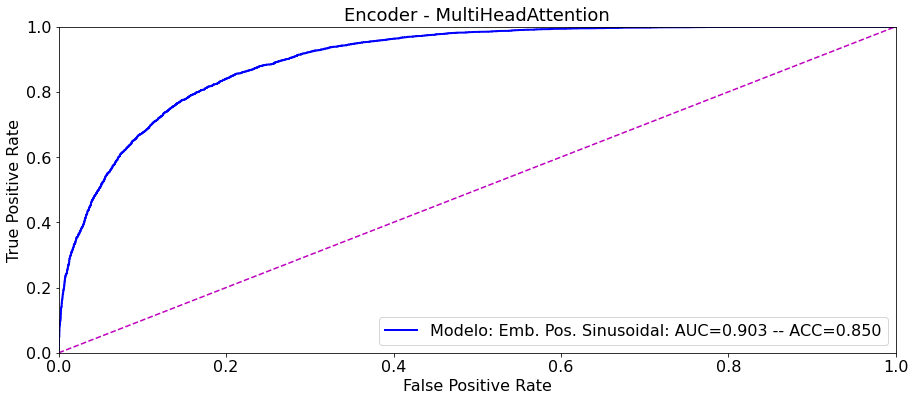

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(y, y_pred):
  fpr, tpr,_ = roc_curve(y, y_pred)
  roc_auc    = auc(fpr, tpr)
  acc        = accuracy_score(y, y_pred.round())
  
  # plot
  fig = plt.figure()
  plt.figure(figsize=(15, 6))
  plt.plot(fpr,tpr,'b',lw=2,label='%s AUC=%0.3f -- ACC=%0.3f'%('Modelo: Emb. Pos. Sinusoidal:',roc_auc, acc))
  plt.plot([0, 1], [0, 1], 'm--')
  
  # decoração
  plt.xlim([0.0, 1.0])
  plt.xticks(fontsize=16)
  plt.yticks(fontsize=16)
  plt.ylim([0.0, 1.0])
  plt.title('Encoder - MultiHeadAttention', size=18)
  plt.xlabel('False Positive Rate', size=16)
  plt.ylabel('True Positive Rate', size=16)
  plt.legend(loc=0, fontsize=16)
  plt.show()

plot_roc_curve(y, y_pred)

# <span style="color:purple">Fim do notebook



